<a href="https://colab.research.google.com/github/MiguelOva/text_mining/blob/main/Bert_with_Tensorlfow_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Text Mining Project

#### Spring 2022
#### Opinion Mining Evaluation Forum

#### Students m20200246 Pedro Costa & m2019XXXX Ana Bernardes

In [2]:
### Data import

# -------------------------------------------------------------------
## Data Loading and pre processing

In [1]:
# Loading file 
import pandas as pd
#df = pd.read_csv('training_set.txt', delimiter = '\t')
df_dev = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/dev_set.txt', delimiter = '\t')
df_train = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/training_set.txt', delimiter = '\t')
df_test = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/test_set.txt', delimiter = '\t')

In [2]:
import matplotlib as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
len(df_train)

14000

In [4]:
df_train.head()

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


In [5]:
df_train = pd.DataFrame(data=df_train, columns=['sentence', 'emotion'])

In [6]:
df_train[100:400]

,sentence,emotion
100,What is the matter with you ?,1
101,"Ah , yes ! ' I had a migraine , your Majesty .",8
102,He was ... fine .,3
103,The best died there .,6
104,"What the hell is going on out there , [PERSON] ?",4
...,...,...
395,This is maybe the most important case that we ...,8
396,You think [PERSON]'s gonna buy that ?,4
397,"It's OK , I was thinking the same thing .",8
398,This is the captain speaking .,4


In [7]:
# Check for empty cells

"""""
Avaliar a necessidade de filtrar sentences vazias
"""""

df_train.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [8]:
# Check emotion frequency
df_train.emotion.value_counts()

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

In [9]:
from tqdm import tqdm_notebook as tqdm
def label_counter(df, field):
    """
    ???????????
    """
    return df[field].value_counts()

In [10]:
label_counter(df_train, "emotion")

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

In [11]:
# Word Count
def word_count(text):
    """
    Function that counts text words
    """
    df_words = " ".join(text).split()
    # Count all words 
    freq = pd.Series(df_words).value_counts()
    return freq

In [12]:
word_count(list(df_train['sentence']))[:25]

.           10600
,            5738
you          3502
I            3208
to           2862
the          2703
?            2696
a            2320
!            1608
[PERSON]     1386
of           1358
and          1266
me           1195
it           1193
that         1156
in           1083
You           950
is            902
for           847
be            761
this          757
I'm           738
have          727
your          690
my            678
dtype: int64

In [13]:
#### Preprocessing

In [14]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from bs4 import BeautifulSoup

nltk.download('wordnet')
nltk.download('stopwords')

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
stem = SnowballStemmer("english")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def clean(text_in, lemmatize, stemmer):
    """
    Preprocessing Function  will consist of   
    - make everything lowercased
    - removing all symbols that are not letters
    - remove stopwords
    - replace words with the corresponding lemma

    """
    updates = []
    for j in tqdm(range(len(text_in))):
        
        text = text_in[j]
        
        #make everything lowercased
        text = text.lower()      
          
        #removing all symbols that are not letters
        #text = re.sub("[^a-zA-Z]", ' ', text)
            
        #remove stopwords -- TO REMOVE 
        # text = ' '.join([word for word in text.split() if word not in stop])
        
        #replace words with the corresponding lemma
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(stem.stemmer(word) for word in text.split())
        
        updates.append(text)
        
    return updates

In [17]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 5.1 MB/s 


In [16]:
# Neattext stopword removal 
import neattext.functions as nfx
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [17]:
df_train['sentence'] = df_train['sentence'].apply(nfx.remove_stopwords)
df_train['sentence'] = df_train['sentence'].apply(nfx.remove_punctuations)
df_train['sentence'] = df_train['sentence'].apply(nfx.remove_special_characters)
#df_train.head()


In [18]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"sentence": list_updated}))


updates = clean(df_train["sentence"], lemmatize = True, stemmer = False)
update_df(df_train, updates)
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/14000 [00:00<?, ?it/s]

,sentence,emotion
0,im old traded,6
1,mother said tell lady hand,8
2,said id leave time came,6
3,hell safe,2
4,lay,1


In [19]:
# Word count clean dataframe
#word_count(df_train['sentence'])[:20]

# -------------------------------------------------------------------
## Bert Claf1 with Tensorflow - Def Clean + NeatText

In [22]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.7 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

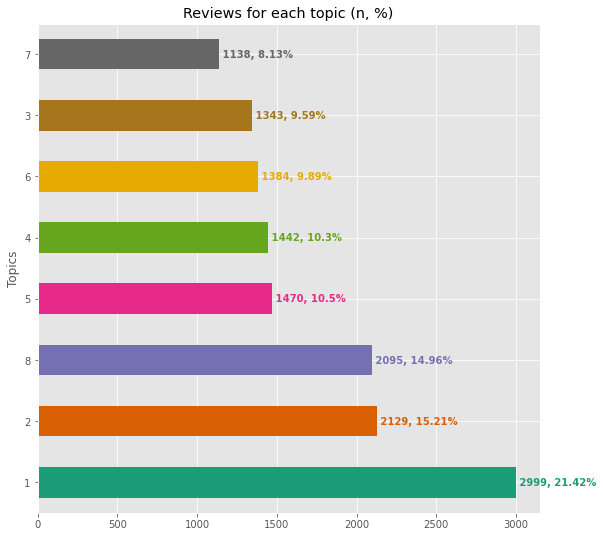

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df_train["emotion"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df_train['emotion'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df_train['emotion'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df_train.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')
  


In [22]:
  # map topic descriptions to labels
df_train['Labels'] = df_train['emotion'].map({1: 0,
                                            2: 1,
                                            3: 2,
                                            4: 3,
                                            5: 4,
                                            6: 5,
                                            7: 6,
                                            8: 7})

# drop unused column
df_train = df_train.drop(["emotion"], axis=1)

df_train.head()

,sentence,Labels
0,im old traded,5
1,mother said tell lady hand,7
2,said id leave time came,5
3,hell safe,1
4,lay,0


In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df_train["Labels"].values, num_classes=num_classes)


# Try to alter test size to 0.20 to improve results 
x_train, x_test, y_train, y_test = train_test_split(df_train['sentence'], y, test_size=0.2)

In [40]:
#!pip install tensorflow_text

In [41]:
#!pip install -U tensorflow-text==2.5

In [42]:
#!pip install tensorflow_hub

In [24]:
#for Colab users: 
#!pip install tensorflow_text
#!pip install -U tensorflow-text==2.5

#for Colab users: 
#!pip install tensorflow_hub

import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


In [25]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
# Before fitting the model, apply pipeline to improve results
# Making the process of training our model faster and automated, we will use a machine learning pipeline. 
# Machine learning pipelines automate the machine learning workflows such as model fitting and training.
from sklearn.pipeline import Pipeline

#  pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

In [26]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy")
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
350/350 [==============================] - 163s 409ms/step - loss: 1.9754 - accuracy: 0.2421 - val_loss: 1.8318 - val_accuracy: 0.3136
Epoch 2/20
350/350 [==============================] - 145s 416ms/step - loss: 1.8079 - accuracy: 0.3259 - val_loss: 1.7755 - val_accuracy: 0.3404
Epoch 3/20
350/350 [==============================] - 145s 414ms/step - loss: 1.7633 - accuracy: 0.3470 - val_loss: 1.7702 - val_accuracy: 0.3393
Epoch 4/20
350/350 [==============================] - 144s 412ms/step - loss: 1.7336 - accuracy: 0.3574 - val_loss: 1.7571 - val_accuracy: 0.3589
Epoch 5/20
350/350 [==============================] - 144s 413ms/step - loss: 1.7228 - accuracy: 0.3650 - val_loss: 1.7512 - val_accuracy: 0.3521
Epoch 6/20
350/350 [==============================] - 144s 413ms/step - loss: 1.7152 - accuracy: 0.3656 - val_loss: 1.7535 - val_accuracy: 0.3475
Epoch 7/20
350/350 [==============================] - 145s 413ms/step - loss: 1.7084 - accuracy: 0.3671 - val_loss: 1.7475 -

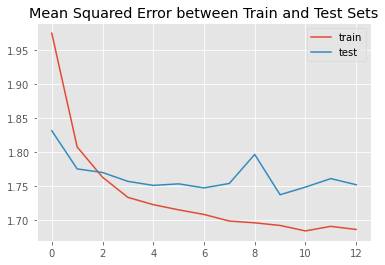

In [27]:
# plot history
import matplotlib.pyplot as pyplot 
pyplot.plot(model_fit.history['loss'], label='train')
pyplot.plot(model_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [28]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


# Cleaning dev df for model predictions

In [29]:
df_dev.head()

,sentence,emotion
0,What happens to the gold in our safe ?,4
1,Natural to get cold feet .,8
2,"Not very lucky , is he ?",7
3,I'm just a little anxious to get up there and ...,2
4,Did you think we don't know about your affair ...,1


In [30]:
df_dev['sentence'] = df_dev['sentence'].apply(nfx.remove_stopwords)
df_dev['sentence'] = df_dev['sentence'].apply(nfx.remove_punctuations)
df_dev['sentence'] = df_dev['sentence'].apply(nfx.remove_special_characters)


,sentence,emotion
0,happens gold safe,4
1,Natural cold feet,8
2,lucky,7
3,Im little anxious whoop ETs ass thats,2
4,think know affair government official,1


In [31]:
# Clean dev dataset for predictions
updates = clean(df_dev["sentence"], lemmatize = True, stemmer = False)

update_df(df_dev, updates)

  0%|          | 0/1000 [00:00<?, ?it/s]

,sentence,emotion
0,happens gold safe,4
1,natural cold foot,8
2,lucky,7
3,im little anxious whoop ets as thats,2
4,think know affair government official,1
...,...,...
995,ask careful,4
996,like jazz pal,7
997,,1
998,imagine person spot like,7


In [32]:
# map topic descriptions to labels
df_dev['Labels'] = df_dev['emotion'].map({1: 0,
                                            2: 1,
                                            3: 2,
                                            4: 3,
                                            5: 4,
                                            6: 5,
                                            7: 6,
                                            8: 7})

# drop unused column
df_dev = df_dev.drop(["emotion"], axis=1)

df_dev.head()

,sentence,Labels
0,happens gold safe,3
1,natural cold foot,7
2,lucky,6
3,im little anxious whoop ets as thats,1
4,think know affair government official,0


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = predict_class(df_dev["sentence"])

              precision    recall  f1-score   support

           0       0.32      0.62      0.42       211
           1       0.35      0.37      0.36       170
           2       0.26      0.18      0.21        77
           3       0.44      0.15      0.23       104
           4       0.41      0.44      0.43        97
           5       0.34      0.29      0.31        87
           6       0.45      0.09      0.16        96
           7       0.38      0.31      0.34       158

    accuracy                           0.35      1000
   macro avg       0.37      0.31      0.31      1000
weighted avg       0.37      0.35      0.33      1000

Accuracy: 34.90%

F1 Score: 34.90


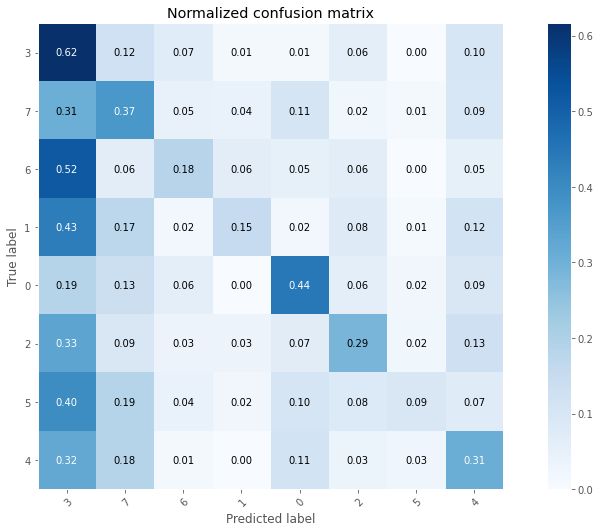

In [34]:
class_names = df_dev['Labels'].unique().tolist()

print(classification_report(df_dev["Labels"], y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(df_dev['Labels'], y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_dev['Labels'], y_pred, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_dev['Labels'], y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# -------------------------------------------------------------------
# Classifier 2 - Bert with mixed df

In [35]:
# Loading file 
import pandas as pd
#df = pd.read_csv('training_set.txt', delimiter = '\t')
df_dev = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/dev_set.txt', delimiter = '\t')
df_train = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/training_set.txt', delimiter = '\t')
df_test = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/test_set.txt', delimiter = '\t')

In [36]:
df_mix = df_train.append(df_dev, ignore_index=True)

In [37]:
df_mix['sentence'] = df_mix['sentence'].apply(nfx.remove_stopwords)
df_mix['sentence'] = df_mix['sentence'].apply(nfx.remove_punctuations)
df_mix['sentence'] = df_mix['sentence'].apply(nfx.remove_special_characters)

In [38]:
# Clean dev dataset for predictions
updates = clean(df_mix["sentence"], lemmatize = True, stemmer = False)

update_df(df_mix, updates)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [39]:
# map topic descriptions to labels
df_mix['Labels'] = df_mix['emotion'].map({1: 0,
                                            2: 1,
                                            3: 2,
                                            4: 3,
                                            5: 4,
                                            6: 5,
                                            7: 6,
                                            8: 7})

# drop unused column
df_mix = df_mix.drop(["emotion"], axis=1)

df_mix.head()

,sentence,Labels
0,im old traded,5
1,mother said tell lady hand,7
2,said id leave time came,5
3,hell safe,1
4,lay,0


In [43]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df_mix["Labels"].values, num_classes=num_classes)


# Try to alter test size to 0.20 to improve results 
x_train, x_test, y_train, y_test = train_test_split(df_mix['sentence'], y, test_size=0.2)

In [44]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [45]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model_2 = tf.keras.Model(i, x)

In [47]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy")
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model_2.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model_2.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
375/375 [==============================] - 180s 419ms/step - loss: 1.9820 - accuracy: 0.2393 - val_loss: 1.8266 - val_accuracy: 0.3170
Epoch 2/20
375/375 [==============================] - 155s 414ms/step - loss: 1.8138 - accuracy: 0.3198 - val_loss: 1.7798 - val_accuracy: 0.3350
Epoch 3/20
375/375 [==============================] - 155s 415ms/step - loss: 1.7613 - accuracy: 0.3451 - val_loss: 1.7380 - val_accuracy: 0.3577
Epoch 4/20
375/375 [==============================] - 155s 414ms/step - loss: 1.7430 - accuracy: 0.3523 - val_loss: 1.7384 - val_accuracy: 0.3537
Epoch 5/20
375/375 [==============================] - 155s 415ms/step - loss: 1.7294 - accuracy: 0.3562 - val_loss: 1.7447 - val_accuracy: 0.3607
Epoch 6/20
375/375 [==============================] - 155s 414ms/step - loss: 1.7207 - accuracy: 0.3657 - val_loss: 1.7344 - val_accuracy: 0.3493
Epoch 7/20
375/375 [==============================] - 155s 415ms/step - loss: 1.7218 - accuracy: 0.3647 - val_loss: 1.7325 -

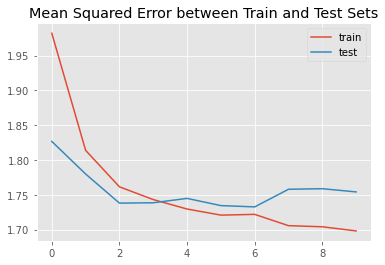

In [48]:
# plot history
import matplotlib.pyplot as pyplot 
pyplot.plot(model_fit.history['loss'], label='train')
pyplot.plot(model_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [ ]:
# ##Preprocessing
# !pip install neattext
# import neattext.functions as nfx
# dir(nfx)

In [ ]:
# df1['clean_sentence'] = df1['sentence'].apply(nfx.remove_stopwords)